# Command line interface example

The PCNtoolkit is commonly used as a python package, but it can also be used from the command line. 

This example shows how to use the PCNtoolkit from the command line. We use python here to make the code more readable, but you can also use the command line directly.

Furthermore, you can use this script to generate commands for the command line interface.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os

import pickle

## BLR Example 

### Data preparation

In [2]:
# Download and split data first
# If you are running this notebook for the first time, you need to download the dataset from github.
# If you have already downloaded the dataset, you can comment out the following line
pd.read_csv(
    "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
).to_csv("resources/data/fcon1000.csv", index=False)

In [3]:
data = pd.read_csv("resources/data/fcon1000.csv")

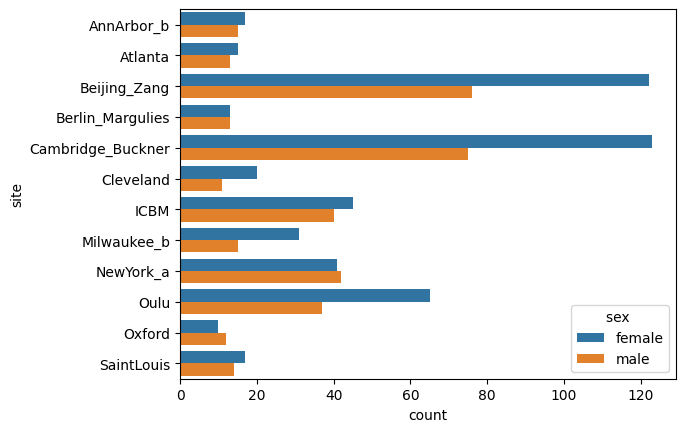

In [4]:
# Remove small sites and sites with only one sex
data["sex "] = np.where(data["sex"] == 1, ["male"], ["female"])
site_counts = data.groupby(["site", "sex"]).size().reset_index(name="counts")  # type: ignore
sex_count_per_site = site_counts["site"].value_counts()
sites_with_one_sex = sex_count_per_site[sex_count_per_site == 1]
sites_with_one_sex.index
data = data[~data["site"].isin(sites_with_one_sex.index)]
site_counts = site_counts[site_counts["counts"] < 10]
data = data[~data["site"].isin(site_counts["site"])]
sns.countplot(data=data, y="site", hue="sex ", orient="v")
plt.show()

In [5]:
covariate_columns = ["age"]
batch_effect_columns = ["sex", "site"]
response_columns = ["rh_MeanThickness_thickness", "WM-hypointensities"]

In [6]:
X = data[covariate_columns]
Y = data[response_columns]
batch_effects = data[batch_effect_columns]

batch_effects_strings = [str(b[0]) + " " + str(b[1]) for b in batch_effects.values]

trainidx, testidx = train_test_split(data.index, test_size=0.2, random_state=42, stratify=batch_effects_strings)
train_X = X.loc[trainidx]
train_Y = Y.loc[trainidx]
train_batch_effects = batch_effects.loc[trainidx]

test_X = X.loc[testidx]
test_Y = Y.loc[testidx]
test_batch_effects = batch_effects.loc[testidx]

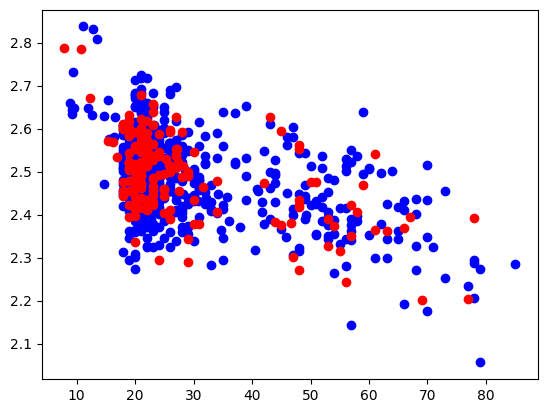

In [7]:
plt.scatter(train_X["age"], train_Y["rh_MeanThickness_thickness"], c="blue")
plt.scatter(test_X["age"], test_Y["rh_MeanThickness_thickness"], c="red")
plt.show()

In [8]:
root_dir = os.path.join("resources", "cli_example")
data_dir = os.path.join(root_dir, "data")
os.makedirs(data_dir, exist_ok=True)

resp = os.path.abspath(os.path.join(data_dir, "responses.csv"))
cov = os.path.abspath(os.path.join(data_dir, "covariates.csv"))
be = os.path.abspath(os.path.join(data_dir, "batch_effects.csv"))

t_resp = os.path.abspath(os.path.join(data_dir, "test_responses.csv"))
t_cov = os.path.abspath(os.path.join(data_dir, "test_covariates.csv"))
t_be = os.path.abspath(os.path.join(data_dir, "test_batch_effects.csv"))


with open(cov, "wb") as f:
    pickle.dump(train_X, f)
with open(resp, "wb") as f:
    pickle.dump(train_Y, f)
with open(be, "wb") as f:
    pickle.dump(train_batch_effects, f)
with open(t_cov, "wb") as f:
    pickle.dump(test_X, f)
with open(t_resp, "wb") as f:
    pickle.dump(test_Y, f)
with open(t_be, "wb") as f:
    pickle.dump(test_batch_effects, f)

### BLR configuration

In [9]:
alg = "blr"
func = "fit_predict"

# normative model configuration
save_dir = os.path.join(root_dir, "blr", "save_dir")
savemodel = True
saveresults = True
basis_function = "linear"
inscaler = "standardize"
outscaler = "standardize"

# runner configuration
cross_validate = True
cv_folds = 5
parallelize = True
job_type = "local"
n_jobs = 2
temp_dir = os.path.join(root_dir, "temp")
log_dir = os.path.join(root_dir, "log")

# Regression model configuration
optimizer = "l-bfgs-b"
n_iter = 200
heteroskedastic = True
random_intercept = True
warp = "WarpSinhArcsinh"
warp_reparam = True

### Constructing command

In [10]:
command = "normative"
args = f"-a {alg} -f {func} -c {cov} -r {resp} -t {t_resp} -e {t_cov}"
kwargs = f"be={be} t_be={t_be}"
normative_model_kwargs = f"save_dir={save_dir} savemodel={savemodel} saveresults={saveresults} basis_function={basis_function} inscaler={inscaler} outscaler={outscaler}"
runner_kwargs = f"cross_validate={cross_validate} cv_folds={cv_folds} parallelize={parallelize} job_type={job_type} n_jobs={n_jobs} temp_dir={temp_dir} log_dir={log_dir}"
blr_kwargs = f"optimizer={optimizer} n_iter={n_iter} heteroskedastic={heteroskedastic} random_intercept={random_intercept} warp={warp} warp_reparam={warp_reparam}"
full_command = f"{command} {args} {kwargs} {runner_kwargs} {normative_model_kwargs} {blr_kwargs}"

### Running command

In [11]:
!{full_command}

No python path specified. Using interpreter path of current process: /opt/anaconda3/envs/param2/bin/python
Configuration of normative model is valid.
Configuration of regression model is valid.
/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pcntoolkit/util/runner.py:131: UserWarning: predict_data is not used in kfold cross-validation
  warnings.warn("predict_data is not used in kfold cross-validation")
Going to fit and predict 1 models
Fitting and predicting model for response_var_0
21729 Saving model to resources/cli_example/blr/save_dir/folds/fold_0
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/cli_example/blr/save_dir/folds/fold_0/model
Computing zscores for response_var_0
Computing centiles for response_var_0
/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Computing centiles for re

You can find the results in the resources/cli_example/blr/save_dir folder.

In [12]:
import pandas as pd

a = pd.read_csv(
    "/Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/cli_example/blr/save_dir/folds/fold_1/results/measures.csv",
    index_col=0,
)

## HBR example

In [13]:
alg = "hbr"
func = "fit_predict"

# normative model configuration
save_dir = os.path.join(root_dir, "hbr", "save_dir")
savemodel = True
saveresults = True
basis_function = "bspline"
inscaler = "standardize"
outscaler = "standardize"


# Regression model configuration
draws = 1000
tune = 500
chains = 4
nuts_sampler = "nutpie"

likelihood = "Normal"
linear_mu = "True"
random_intercept_mu = "True"
random_slope_mu = "False"
linear_sigma = "True"
random_intercept_sigma = "False"
random_slope_sigma = "False"

### Constructing command

In [14]:
command = "normative"
args = f"-a {alg} -f {func} -c {cov} -r {resp} -t {t_resp} -e {t_cov}"
kwargs = f"be={be} t_be={t_be}"
normative_model_kwargs = f"save_dir={save_dir} savemodel={savemodel} saveresults={saveresults} basis_function={basis_function} inscaler={inscaler} outscaler={outscaler}"
hbr_kwargs = f"draws={draws} tune={tune} chains={chains} nuts_sampler={nuts_sampler} likelihood={likelihood} linear_mu={linear_mu} random_intercept_mu={random_intercept_mu} random_slope_mu={random_slope_mu} linear_sigma={linear_sigma} random_intercept_sigma={random_intercept_sigma} random_slope_sigma={random_slope_sigma}"
full_command = f"{command} {args} {kwargs} {normative_model_kwargs} {hbr_kwargs}"

### Running command


In [15]:
!{full_command}

No python path specified. Using interpreter path of current process: /opt/anaconda3/envs/param2/bin/python
No log directory specified. Using default log directory: /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/logs
No temp directory specified. Using default temp directory: /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/temp
/opt/anaconda3/envs/param2/lib/python3.12/site-packages/pcntoolkit/util/runner.py:87: UserWarning: cv_folds is greater than 1, but cross-validation is disabled. This is likely unintended.
  warnings.warn("cv_folds is greater than 1, but cross-validation is disabled. This is likely unintended.")
Configuration of normative model is valid.
Going to fit and predict 2 models
Fitting and predicting model for response_var_0
██████████████████████████████████████████████████████████████████████ 6000/6000Sampling: [y_pred]
Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00/ 0:00:00
Fitting and predicting model for respon